In [1]:
import time
import torch
import matplotlib.pyplot as plt

import escnn.nn as enn
import escnn.gspaces as gspaces

from molnet.escnn_models import MaskModule3D

from itertools import product, repeat
import math


In [2]:
x = torch.rand(4, 1, 32, 32, 32)

r2_act = gspaces.rot2dOnR3(n=-1)
in_type = enn.FieldType(r2_act, [r2_act.trivial_repr])
print(in_type.gspace.dimensionality)
x = in_type(x)

3


Time: 0.0002827644348144531
torch.Size([4, 1, 32, 32, 32])


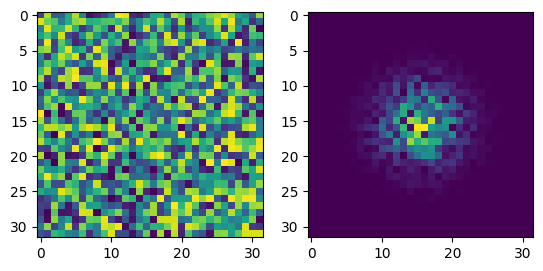

In [3]:
mask = enn.MaskModule(in_type, 32, margin=2, sigma=5)
t0 = time.time()
y = mask(x)
print('Time:', time.time() - t0)

print(y.shape)
ax = plt.subplot(1, 2, 1)
ax.imshow(x.tensor[0,0,...,-1].detach().numpy())

ax = plt.subplot(1, 2, 2)
ax.imshow(y.tensor[0,0,...,-1].detach().numpy())

torch.Size([1, 1, 128, 128, 10])


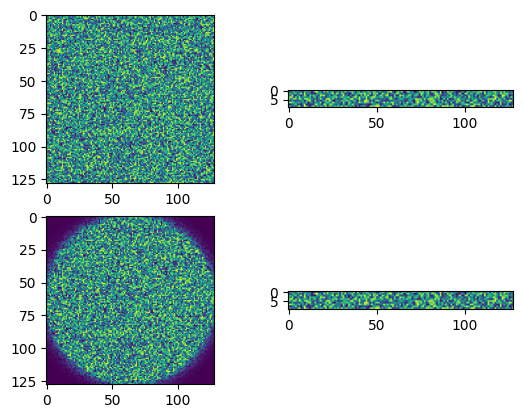

In [18]:
sh = (128, 128, 10)
mask_fn = MaskModule3D(in_type, sh, margin=0, sigma=20)
x = torch.rand(4, 1, *sh)
x = in_type(x)
y = mask_fn(x)

x = x.tensor
y = y.tensor

ax = plt.subplot(2, 2, 1)
ax.imshow(x[0, 0, ..., 0].detach().numpy())

ax = plt.subplot(2, 2, 2)
ax.imshow(x[0, 0, ..., 64, :].T.detach().numpy())

ax = plt.subplot(2, 2, 3)
ax.imshow(y[0, 0, ..., 0].detach().numpy())

ax = plt.subplot(2, 2, 4)
ax.imshow(y[0, 0, ..., 64, :].T.detach().numpy())